In [25]:
%pip install pymc arviz

import sys
import os

# Ensure src/ is discoverable
sys.path.append(os.path.abspath(".."))

from src.models.change_point import fit_mean_change_point_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (12, 5)
az.style.use("arviz-darkgrid")


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Load and Prepare Data

In [12]:
def load_price_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

    if df["Price"].isna().any():
        print("Warning: Missing price values detected")

    return df


df = load_price_data("../data/raw/BrentOilPrices.csv")
df.head()


C:\Users\user\AppData\Local\Temp\ipykernel_17232\2924552250.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


Raw Price EDA

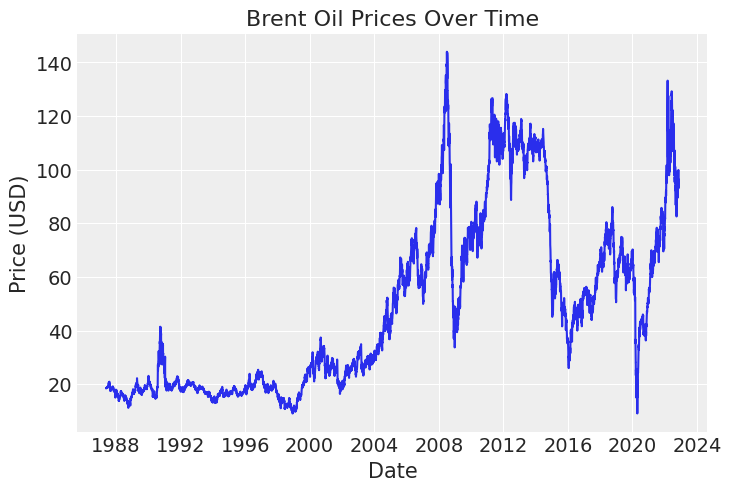

In [13]:
plt.plot(df["Date"], df["Price"])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()


Log Returns & Stationarity

Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


c:\Users\user\AppData\Local\Programs\Python\Python314\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 218 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


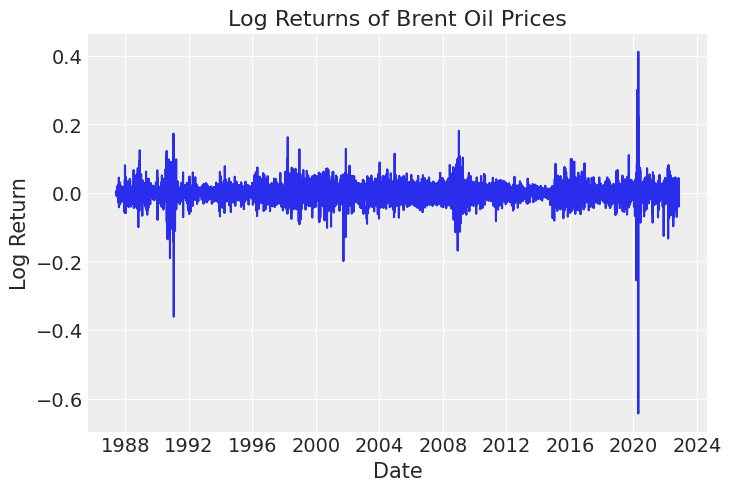

In [26]:
df["log_return"] = np.log(df["Price"]).diff()
df = df.dropna()
returns = df["log_return"].values

model, trace = fit_mean_change_point_model(returns)

plt.plot(df["Date"], df["log_return"])
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


Augmented Dickey-Fuller Test

In [15]:
def adf_test(series):
    result = adfuller(series)
    return {
        "ADF Statistic": result[0],
        "p-value": result[1]
    }

adf_test(df["log_return"])


{'ADF Statistic': np.float64(-16.427113494485894),
 'p-value': np.float64(2.4985801611428892e-29)}

Bayesian Change Point Model

Prepare Data for Modeling

In [16]:
returns = df["log_return"].values
n = len(returns)
time_idx = np.arange(n)

Define the Change Point Model

In [18]:
with pm.Model() as change_point_model:

    # Switch point
    tau = pm.Uniform("tau", lower=0, upper=n - 1)
# After sampling, round to nearest integer:
    #tau_median = int(np.median(trace.posterior["tau"].values))
    # Regime means
    mu_1 = pm.Normal("mu_1", mu=0, sigma=1)
    mu_2 = pm.Normal("mu_2", mu=0, sigma=1)

    # Shared volatility
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Mean switches at tau
    mu = pm.math.switch(time_idx <= tau, mu_1, mu_2)

    # Likelihood
    likelihood = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)

    trace = pm.sample(
        draws=10,
        tune=10,
        target_accept=0.9,
        return_inferencedata=True
    )
    # Use a subset of data
returns = df["log_return"].values[:500]  # First 500 points
n = len(returns)


Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu_1, mu_2, sigma]


c:\Users\user\AppData\Local\Programs\Python\Python314\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 380 seconds.
The number of samples is too small to check convergence reliably.


Model Diagnostics & Outputs

Convergence Check

In [19]:
az.summary(trace, var_names=["tau", "mu_1", "mu_2", "sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,4904.563,1137.524,3199.839,6361.050,359.715,177.414,11.0,20.0,3.97
mu_1,0.024,0.448,-0.551,0.587,0.139,0.043,11.0,20.0,3.59
mu_2,-0.100,0.331,-0.834,0.215,0.099,0.083,11.0,20.0,3.08
sigma,1.044,0.600,0.147,2.013,0.184,0.075,11.0,20.0,2.70


Trace Plots

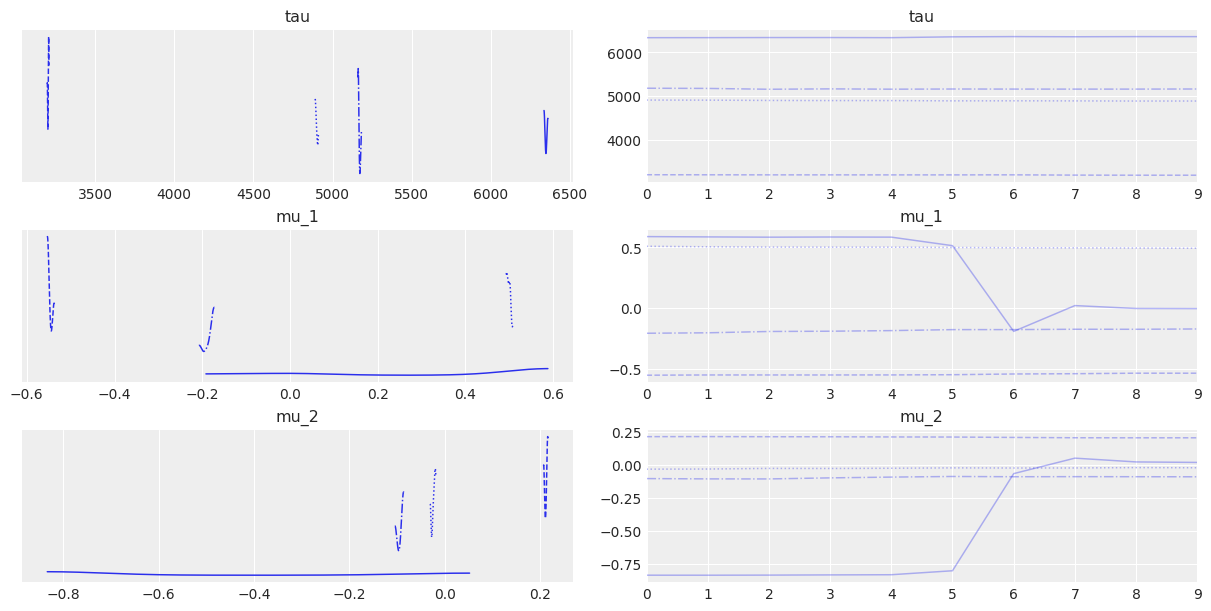

In [20]:
az.plot_trace(trace, var_names=["tau", "mu_1", "mu_2"])
plt.show()


Posterior Distribution of Change Point

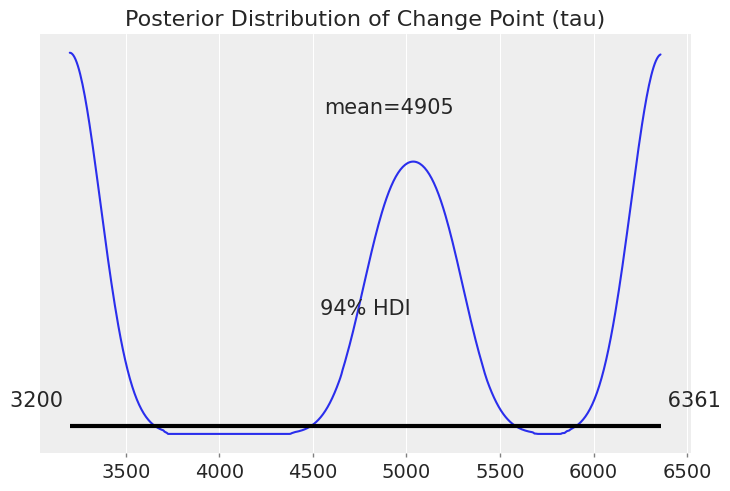

In [21]:
az.plot_posterior(trace, var_names=["tau"])
plt.title("Posterior Distribution of Change Point (tau)")
plt.show()


Quantifying the Impact

Before vs After Impact

In [22]:
mu1_samples = trace.posterior["mu_1"].values.flatten()
mu2_samples = trace.posterior["mu_2"].values.flatten()

impact_pct = (mu2_samples - mu1_samples) / np.abs(mu1_samples) * 100

np.percentile(impact_pct, [5, 50, 95])


array([-242.22267323,   49.41510414,  177.05276319])

Associate Change Point with Events

Map Tau to Date

In [23]:
tau_median = int(np.median(trace.posterior["tau"].values))
change_date = df.iloc[tau_median]["Date"]

change_date


Timestamp('2007-03-01 00:00:00')

Future extensions include incorporating macroeconomic variables (GDP, inflation, exchange rates), VAR models for multivariate dynamics, and Markov-switching models to explicitly capture calm vs volatile regimes.